In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import os.path
import csv
tf.reset_default_graph()

C:\Users\tkdid\Anaconda3\envs\rnn\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\tkdid\Anaconda3\envs\rnn\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\tkdid\Anaconda3\envs\rnn\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\tkdid\Anaconda3\envs\rnn\lib\site-packages\tensorflow\python\framework

In [2]:
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원

# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [3]:
# 하이퍼파라미터
input_data_column_cnt = 6  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 6 # 결과데이터의 컬럼 개수

seq_length = 28            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 120   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 7     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율

epoch_num = 1000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률

predict_days = 30          # 미래의 몇일을 예측할것인지 설정

In [4]:
# 데이터를 로딩한다.
stock_file_name = 'AAPL_5Y.csv' # 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

today = raw_dataframe.values[-1, 0]
print("today = ", today)

# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과

stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
Date         1259 non-null object
Open         1259 non-null object
High         1259 non-null object
Low          1259 non-null object
Close        1259 non-null object
Adj Close    1259 non-null object
Volume       1259 non-null object
dtypes: object(7)
memory usage: 68.9+ KB
today =  2020-03-06
stock_info.shape:  (1258, 6)
stock_info[0]:  [1.26410004e+02 1.27220001e+02 1.23800003e+02 1.24510002e+02
 1.14581505e+02 6.88566000e+07]


In [5]:
# 데이터 전처리
# 가격과 거래량 수치의 차이가 많아나서 각각 별도로 정규화한다

# 가격형태 데이터들을 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 'Adj Close'까지 취함
# 곧, 마지막 열 Volume를 제외한 모든 열
price = stock_info[:,:-1]
    
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리
print("price.shape: ", price.shape)
print("price[0]: ", price[0])
print("norm_price[0]: ", norm_price[0])
print("="*100) # 화면상 구분용

# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-1:]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) # 화면상 구분용

y = x # 타켓은 주식이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

price.shape:  (1258, 5)
price[0]:  [126.410004 127.220001 123.800003 124.510002 114.581505]
norm_price[0]:  [0.16985736 0.1731954  0.15910144 0.16202738 0.12111163]
volume.shape:  (1258, 1)
volume[0]:  [68856600.]
norm_volume[0]:  [0.38115196]
x.shape:  (1258, 6)
x[0]:  [0.16985736 0.1731954  0.15910144 0.16202738 0.12111163 0.38115196]
x[-1]:  [0.81105022 0.84739783 0.80787706 0.84002113 0.84002113 0.29952872]
y[0]:  [0.16985736 0.1731954  0.15910144 0.16202738 0.12111163 0.38115196]
y[-1]:  [0.81105022 0.84739783 0.80787706 0.84002113 0.84002113 0.29952872]


In [6]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다
X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, output_data_column_cnt])
print("Y: ", Y)

predictions = tf.placeholder(tf.float32, [None, output_data_column_cnt])
print("predictions: ", predictions)

X:  Tensor("Placeholder:0", shape=(?, 28, 6), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 6), dtype=float32)
predictions:  Tensor("Placeholder_2:0", shape=(?, 6), dtype=float32)


In [7]:
# 모델(LSTM 네트워크) 생성
def lstm_cell(name):
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.nn.rnn_cell.LSTMCell(num_units=rnn_cell_hidden_dim, 
                                             forget_bias=forget_bias, activation=tf.nn.tanh, name=name)
    
    #cell = tf.keras.layers.LSTMCell(units=rnn_cell_hidden_dim, 
    #                                         unit_forget_bias=forget_bias, activation=tf.nn.tanh)
    
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
#stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
#multi_cells = tf.nn.rnn_cell.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()
#multi_cells = keras.layers.RNN(stackedRNNs)

#multi_cells = tf.keras.layers.StackedRNNCells(stackedRNNs)

#print(multi_cells)

# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM"), X, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_1"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_2"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_3"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_4"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_5"), hypothesis, dtype=tf.float32)
hypothesis, _states = tf.nn.dynamic_rnn(lstm_cell("LSTM_6"), hypothesis, dtype=tf.float32)

#print("hypothesis: ", hypothesis)
#hypothesis, _, _ = tf.contrib.rnn.stack_bidirectional_dynamic_rnn(stackedRNNs, stackedRNNs, X, dtype=tf.float32)


# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 6개를 예측하기때문에 MANY-TO-MANY형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:,-1], output_data_column_cnt, activation_fn=tf.identity)
#hypothesis = tf.keras.layers.Dense(output_data_column_cnt, activation_fn=tf.identity)
print("hypothesis: ", hypothesis)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

hypothesis:  Tensor("fully_connected/Identity:0", shape=(?, 6), dtype=float32)


In [8]:
# The file path to save the data
save_file = './model.ckpt'

saver = tf.train.Saver()
sess = tf.Session()
#writer = tf.summary.FileWriter("C:\\Users\\tkdid\\tensorboard", sess.graph)

if os.path.isfile(save_file+".meta"):
    saver.restore(sess,save_file)
    print("저장된 모델을 불러옵니다")
else:
    sess.run(tf.global_variables_initializer())
    print("존재하는 모델이 없습니다")

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt
저장된 모델을 불러옵니다


In [9]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

time = datetime.datetime.strptime(today, '%Y-%m-%d')


for i in range(predict_days):
    
    # 내일 주가를 예측해본다
    test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

    print("test_predict shape = ", test_predict.shape)
    print("test_predict = ", test_predict)

    test_predict1 = reverse_min_max_scaling(price,test_predict[0, 0:5]) # 금액데이터 역정규화한다
    test_predict2 = reverse_min_max_scaling(volume,test_predict[0, 5]) # 볼륨데이터 역정규화한다
    real_test_predict = np.append(test_predict1, test_predict2)
    #real_test_predict = real_test_predict.astype(np.string_)

    print(test_predict1, test_predict2)
    print(test_predict1.shape, test_predict2.shape)
    

    time = time + datetime.timedelta(days=1)
    str_time = time.strftime("%Y-%m-%d")
    
    print(str_time, "'s stock price", real_test_predict) # 예측한 주가를 출력한다
    
    
    #csv 파일 열고 추가
    f = open("predict.csv", 'a', newline='')
    wr = csv.writer(f)
    wr.writerow([str_time, real_test_predict[0], real_test_predict[1], real_test_predict[2], real_test_predict[3]
            , real_test_predict[4], real_test_predict[5]])
    f.close()
    
    
    #후처리
    recent_data = np.squeeze(recent_data, axis=0)  # [1,28,6] -> [28,6]
    recent_data = np.concatenate((recent_data, test_predict), axis=0)  # 새로 얻은 값 추가
    recent_data = np.delete(recent_data, [0], axis=0)  # 제일 처음값 삭제
    recent_data = np.expand_dims(recent_data, axis=0)  # [28,6] -> [1,28,6]

recent_data.shape: (1, 28, 6)
recent_data: [[[0.93715411 0.96105611 0.93546447 0.9581302  0.95503036 0.19355388]
  [0.98598848 1.         0.97333686 0.9855351  0.98237037 0.28304218]
  [0.9698752  0.98450484 0.9624985  0.98359821 0.98043813 0.13473363]
  [0.97148234 0.97869416 0.91939244 0.92442011 0.92140013 0.25546275]
  [0.90294939 0.94082178 0.89437768 0.9209172  0.91790552 0.21303026]
  [0.9483221  0.96616628 0.94139878 0.96291062 0.95979947 0.15109686]
  [0.98215582 0.987266   0.96332275 0.97362536 0.97048892 0.12161348]
  [0.9782409  0.98916164 0.96872131 0.98912039 0.98594723 0.09940316]
  [0.97741665 0.98166131 0.95940771 0.96777343 0.96777343 0.11971947]
  [0.94366531 0.97403736 0.94230542 0.97403736 0.97403736 0.10590523]
  [0.98248557 0.98372184 0.96233362 0.96604253 0.96604253 0.08100273]
  [0.97370773 0.99740372 0.97370773 0.99732135 0.99732135 0.11316702]
  [0.98491697 0.99328268 0.98145531 0.98771925 0.98771925 0.0817061 ]
  [0.98718349 0.99229367 0.97939479 0.988049   

2020-04-01 's stock price [2.46728455e+02 2.49376862e+02 2.43473450e+02 2.46530273e+02
 2.45674042e+02 2.93164776e+07]
test_predict shape =  (1, 6)
test_predict =  [[0.6620811  0.6730603  0.6486783  0.66136557 0.6574925  0.12097777]]
[245.8516  248.51578 242.5993  245.67795 244.73813] 29610807.674174022
(5,) ()
2020-04-02 's stock price [2.45851593e+02 2.48515778e+02 2.42599304e+02 2.45677948e+02
 2.44738129e+02 2.96108077e+07]
test_predict shape =  (1, 6)
test_predict =  [[0.6585456  0.66958195 0.64516115 0.65792567 0.65373427 0.12282284]]
[244.99368 247.67172 241.74585 244.84323 243.82617] 29889125.850564998
(5,) ()
2020-04-03 's stock price [2.44993683e+02 2.47671722e+02 2.41745850e+02 2.44843231e+02
 2.43826172e+02 2.98891259e+07]
test_predict shape =  (1, 6)
test_predict =  [[0.6549455  0.66599053 0.6416054  0.6543948  0.6499576  0.12460649]]
[244.12009 246.80023 240.88303 243.98645 242.90973] 30158178.779900085
(5,) ()
2020-04-04 's stock price [2.44120087e+02 2.46800232e+02 2.40

In [10]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')

print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')

print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')

# 결과 그래프 출력

recent_data = np.squeeze(recent_data, axis=0)
print(recent_data.shape)

recent_data1 = reverse_min_max_scaling(price,recent_data[:, 0:5])
recent_data2 = reverse_min_max_scaling(volume,recent_data[:, 5])

# 실제 데이터를 로딩한다.
stock_file_name = 'AAPL.csv' # 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과

stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다

# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_real = np.array([stock_info[len(stock_info)-predict_days : ]])
recent_real = np.squeeze(recent_real, axis=0)
print("recent_real = ", recent_real)
print(recent_real.shape)
#print("stock_info = ", stock_info)
#recent_real = stock_info

input_data_column_cnt: 6,output_data_column_cnt: 6,seq_length: 28,rnn_cell_hidden_dim: 120,forget_bias: 1.0,num_stacked_layers: 7,keep_prob: 1.0,epoch_num: 1000,learning_rate: 0.01(28, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9913 entries, 0 to 9912
Data columns (total 7 columns):
Date         9913 non-null object
Open         9913 non-null object
High         9913 non-null object
Low          9913 non-null object
Close        9913 non-null object
Adj Close    9913 non-null object
Volume       9913 non-null object
dtypes: object(7)
memory usage: 542.2+ KB
recent_real =  [[3.00950012e+02 3.02529999e+02 2.86130005e+02 2.88079987e+02
  2.88079987e+02 5.76684000e+07]
 [2.86529999e+02 2.97880005e+02 2.86500000e+02 2.92649994e+02
  2.92649994e+02 4.95137000e+07]
 [2.81100006e+02 2.86000000e+02 2.72959991e+02 2.73519989e+02
  2.73519989e+02 8.01514000e+07]
 [2.57260010e+02 2.78410004e+02 2.56369995e+02 2.73359985e+02
  2.73359985e+02 1.06721200e+08]
 [2.82279999e+02 3.01440002e+02

In [11]:
##########################################################################

# 예측 데이터를 로딩한다.
stock_file_name = 'predict.csv' # 주가데이터 파일
encoding = 'euc-kr' # 문자 인코딩
names = ['Date','Open','High','Low','Close','Adj Close','Volume']
raw_dataframe = pd.read_csv(stock_file_name, names=names, encoding=encoding) #판다스이용 csv파일 로딩
raw_dataframe.info() # 데이터 정보 출력

# raw_dataframe.drop('Date', axis=1, inplace=True) # 시간열을 제거하고 dataframe 재생성하지 않기
del raw_dataframe['Date'] # 위 줄과 같은 효과

stock_info = raw_dataframe.values[1:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다

recent_data = stock_info

print("recent_real = ", recent_data)
print(recent_data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 7 columns):
Date         31 non-null object
Open         31 non-null object
High         31 non-null object
Low          31 non-null object
Close        31 non-null object
Adj Close    31 non-null object
Volume       31 non-null object
dtypes: object(7)
memory usage: 1.8+ KB
recent_real =  [[2.70798676e+02 2.72438324e+02 2.67610565e+02 2.69648315e+02
  2.71973877e+02 1.62540976e+07]
 [2.69179260e+02 2.70905518e+02 2.65853943e+02 2.68141174e+02
  2.70620239e+02 1.75278455e+07]
 [2.66652679e+02 2.68331299e+02 2.62881958e+02 2.65242737e+02
  2.68639862e+02 1.83042078e+07]
 [2.64823151e+02 2.66580597e+02 2.60879730e+02 2.63175568e+02
  2.66886139e+02 1.88033061e+07]
 [2.62556976e+02 2.64308746e+02 2.58407959e+02 2.60612579e+02
  2.64714355e+02 1.90030697e+07]
 [2.60528381e+02 2.62260590e+02 2.56236298e+02 2.58400513e+02
  2.62631989e+02 1.92022028e+07]
 [2.59288025e+02 2.61048462e+02 2.55052246e+02 2.

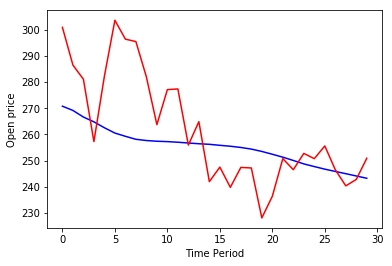

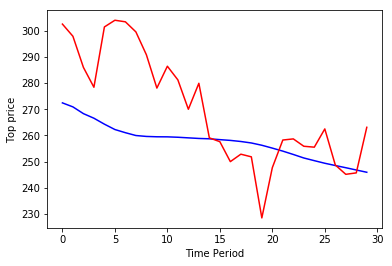

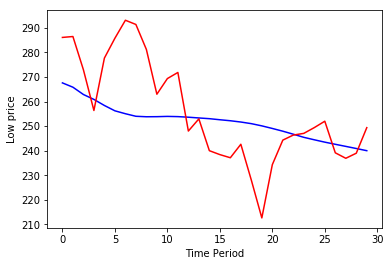

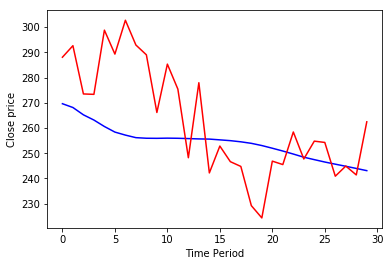

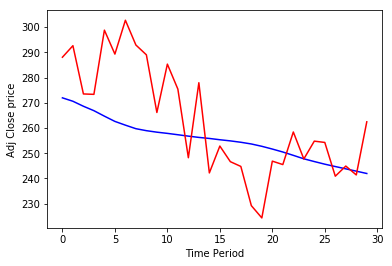

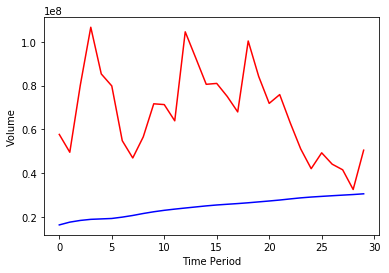

In [12]:
plt.figure(1)
plt.plot(recent_data[:, [0]], 'b')
plt.plot(recent_real[:, [0]], 'r')
plt.xlabel('Time Period')
plt.ylabel('Open price')
plt.show()

plt.figure(2)
plt.plot(recent_data[:, [1]], 'b')
plt.plot(recent_real[:, [1]], 'r')
plt.xlabel('Time Period')
plt.ylabel('Top price')
plt.show()

plt.figure(3)
plt.plot(recent_data[:, [2]], 'b')
plt.plot(recent_real[:, [2]], 'r')
plt.xlabel('Time Period')
plt.ylabel('Low price')
plt.show()

plt.figure(4)
plt.plot(recent_data[:, [3]], 'b')
plt.plot(recent_real[:, [3]], 'r')
plt.xlabel('Time Period')
plt.ylabel('Close price')
plt.show()

plt.figure(5)
plt.plot(recent_data[:, [4]], 'b')
plt.plot(recent_real[:, [4]], 'r')
plt.xlabel('Time Period')
plt.ylabel('Adj Close price')
plt.show()

plt.figure(6)
plt.plot(recent_data[:, [5]], 'b')
plt.plot(recent_real[:, [5]], 'r')
plt.xlabel('Time Period')
plt.ylabel('Volume')
plt.show()